# Imports

In [1]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
import math
import time
from PIL import Image
from scipy import fftpack
#!pip install numba
from numba import jit, prange

# Função de DCT-2D

## Transformada Cosseno Discreta (DCT)

In [2]:
@jit(nopython=True)
def DCT_1D(data):
    N = len(data)
    X = np.zeros(N)
    aK = math.sqrt(2.0/N)
    for k in range(N):
        if (k == 0):
            ck = math.sqrt(1.0/2.0) 
        else:
            ck = 1
        s = 0
        for n in range(N):
            a1 = 2.0 * math.pi * k * n
            a2 = k * math.pi
            nn = 2.0 * N
            s += data[n] * math.cos((a1/nn) + (a2/nn))
        X[k] = aK * ck * s
    return X

## Transformada DCT inversa (IDCT)

In [3]:
@jit(nopython=True)
def IDCT_1D(data):
    N = len(data)
    x = np.zeros(N)
    aK = math.sqrt(2.0/N)
    for n in range(N):
        s = 0
        for k in range(N):
            a1 = 2.0 * math.pi * k * n
            a2 = k * math.pi
            nn = 2.0 * N
            if (k == 0):
                ck = math.sqrt(1.0/2.0)
            else:
                ck = 1  
            s += ck * data[k] * math.cos((a1/nn) + (a2/nn))
        x[n] = aK * s
    return x

### Verificação de DCT & IDCT

In [4]:
array_test = np.array([4.25, 0.08993, 12.5789, -1.87, -325, 2021.2])

X_DCT_1D = DCT_1D(array_test)

X_IDCT_1D = IDCT_1D(X_DCT_1D)

print ("-> Validação das transformadas:")
if(X_IDCT_1D.all() == array_test.all()):
    print("O resultado obtido pela inversa é equivalente aos dados de entrada.")
else:
    print("Houve um erro na trasformação")
    
print ("\nDados de Entrada:")
print([ "{:0.2f}".format(x) for x in array_test ])

print ("\nAplicação da DCT_1D:")
print([ "{:0.2f}".format(x) for x in X_DCT_1D ])

print ("\nAplicação da IDCT_1D:")
print([ "{:0.2f}".format(x) for x in X_IDCT_1D ])

-> Validação das transformadas:
O resultado obtido pela inversa é equivalente aos dados de entrada.

Dados de Entrada:
['4.25', '0.09', '12.58', '-1.87', '-325.00', '2021.20']

Aplicação da DCT_1D:
['698.61', '-989.93', '1007.37', '-962.03', '775.38', '-426.05']

Aplicação da IDCT_1D:
['4.25', '0.09', '12.58', '-1.87', '-325.00', '2021.20']


## Funções auxiliares

In [5]:
def readImageByPath(path):
    imagem = Image.open(path)
    imagem = np.asarray(imagem)
    plt.imshow(imagem, cmap="gray")
    plt.title(path[6:])
    plt.show()
    return imagem

In [6]:
def readVideoByPath(path):
    portion_slice = 2000
    base = 20000
    audio_rate, audio_data = wavfile.read(path)
    # audio_portion = audio_data[base:base+portion_slice]
    audio_portion = audio_data
    audio_data.shape
    #return

In [7]:
def printAudio(data):
    plt.figure('Data', figsize=[20,6])
    plt.plot(data, linewidth=0.5,alpha=1,color="blue")
    plt.title("Audio")
    plt.ylabel("Amplitude")
    plt.show()

## Questão 01

#### 1.1 Exibir o módulo normalizado da DCT de I, sem o nível DC, e o valor (numérico) do nível DC

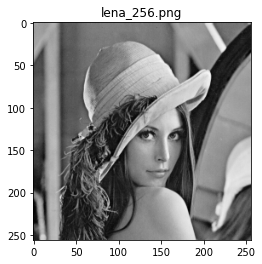

In [8]:
img_input_256 = readImageByPath ("utils/lena_256.png")

In [9]:
#img_input_256 = readImageByPath ("utils/lena.bmp")

### Aplicação de DCT 2D

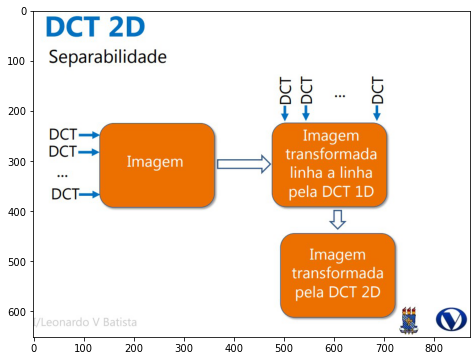

In [10]:
DCT2D_image_slide = Image.open("utils/DCT2D.jpg")
plt.figure(figsize=[60,6])
plt.imshow(DCT2D_image_slide)

In [11]:
imgDCT             = np.zeros(img_input_256.shape)
img_DCT_horizontal = np.zeros(img_input_256.shape)
img_DCT_vertical   = np.zeros(img_input_256.shape)

inicio = time.time()

#DCT nas linhas - horizontal
for i, linha in enumerate(img_input_256): 
    img_DCT_horizontal[i] = DCT_1D(linha)
    
#Transposição dos dados
img_input_vertical = img_DCT_horizontal.T

#DCT nas colunas - vertical
for i, linha in enumerate(img_input_vertical):
    img_DCT_vertical[i] = DCT_1D(linha)

fim = time.time()
print("Tempo de execução: {} segundos".format((fim - inicio)))

Tempo de execução: 1.065234661102295 segundos


### Nível de DC

In [12]:
imgDCT = img_DCT_vertical.T
imgDCT_with_DC = imgDCT.copy()

print("Nivel DC: {}".format(imgDCT[0][0]))

Nivel DC: 31883.60937500001


### DCT com nível DC

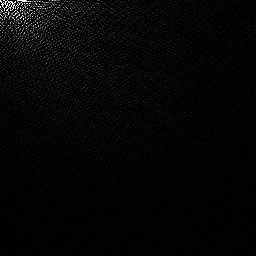

In [13]:
dct_image = Image.fromarray(imgDCT)
dct_image=dct_image.convert("P")
display(dct_image)

### DCT sem nível DC

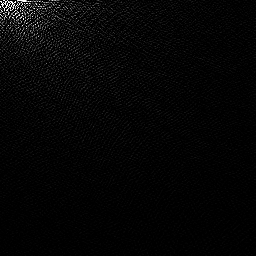

In [14]:
imgDCT[0][0] = 0
dct_image = Image.fromarray(imgDCT)
dct_image=dct_image.convert("P")
display(dct_image)

### Módulo normalizado da DCT

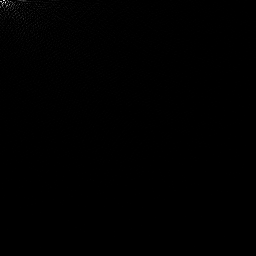

In [15]:
norm_img = imgDCT.copy()
norm_img = norm_img*(255/norm_img.max())

dct_image = Image.fromarray(norm_img)
dct_image=dct_image.convert("P")
display(dct_image)

### 1.2. Encontrar e exibir uma aproximação de I obtida preservando o coeficiente DC e os n coeficientes AC mais importantes de I, e zerando os demais. O parâmetro n é um inteiro no intervalo [0, RxC-1].

 - AC todo mundo sem o primeiro pixel
 - importante = valor mais altos em módulo sem ser o DC
 - separar os n maiores valores em módulos e zerar todos os outros
 - RC-1 -n menores em módulo serão zerados, ou seja os n maiores vão ser preservados
 - deixar o n variável (testar com 100)

In [16]:
img_selected_freq = []
samples=100

In [17]:
imgDCT_original = imgDCT_with_DC.copy() 
print(len(imgDCT_original))

imgDCT_ac = imgDCT_with_DC[1:].copy() 
print(len(imgDCT_ac))

256
255


In [18]:
original_list =  list(np.ndenumerate(imgDCT_original))
print(original_list)

[((0, 0), 31883.60937500001), ((0, 1), -2608.818488463658), ((0, 2), -609.0811734528745), ((0, 3), 2472.017894491721), ((0, 4), 2101.0396664446284), ((0, 5), -1144.1520189161), ((0, 6), -311.617817547497), ((0, 7), 1018.1795819675697), ((0, 8), -491.5907141150633), ((0, 9), -1074.3006439957603), ((0, 10), -1576.5653297895824), ((0, 11), -1920.7826236872777), ((0, 12), -1298.6451846817617), ((0, 13), -648.8067078189143), ((0, 14), -948.2609839209706), ((0, 15), -509.85631414475984), ((0, 16), -110.92865325154413), ((0, 17), 235.07129092382283), ((0, 18), 338.0816022529256), ((0, 19), 519.8803737624835), ((0, 20), 695.8043983266374), ((0, 21), 418.55258776917805), ((0, 22), 435.78929139852386), ((0, 23), 676.8907887980739), ((0, 24), 421.8564519382187), ((0, 25), 433.58743480603977), ((0, 26), 148.8787044020717), ((0, 27), -172.6892938300268), ((0, 28), -410.14680856083925), ((0, 29), -516.357311672833), ((0, 30), -237.0412136273322), ((0, 31), -190.21289643900263), ((0, 32), -170.090403

In [34]:
dc = list(np.ndenumerate(imgDCT_ac))
print(dc)

[((0, 0), 1774.7127519667617), ((0, 1), 1949.8290837843458), ((0, 2), -1624.0820737005408), ((0, 3), -603.9812663841495), ((0, 4), -583.5882742467959), ((0, 5), 809.3004215587694), ((0, 6), 356.6349151744519), ((0, 7), -548.8120828607478), ((0, 8), 1120.165975776208), ((0, 9), 120.10529571617582), ((0, 10), 1103.742258914736), ((0, 11), 364.8237040323323), ((0, 12), 93.19396411764681), ((0, 13), -224.78412986153728), ((0, 14), -30.92559917794457), ((0, 15), 292.8360068233002), ((0, 16), -63.54739307174839), ((0, 17), 132.11917481817915), ((0, 18), 0.7438176899674682), ((0, 19), -535.2119832309646), ((0, 20), -174.2645926978223), ((0, 21), 86.41534242764197), ((0, 22), 187.13551977353387), ((0, 23), 406.4228522199714), ((0, 24), 268.38956820397567), ((0, 25), 268.25429743189267), ((0, 26), 198.1522852562576), ((0, 27), 132.10111951441687), ((0, 28), 301.13532045051653), ((0, 29), 131.76678660130983), ((0, 30), 297.9970221497396), ((0, 31), 104.81709269657787), ((0, 32), 121.622964599800

In [19]:
def sortKey(e): #index 1 means second element
    return e[1]

data_sorted =  list(np.ndenumerate(imgDCT_ac))
data_sorted.sort(key=sortKey)
data_sorted_ac =data_sorted
print(data_sorted_ac)


[((2, 6), -1695.181750344203), ((0, 2), -1624.0820737005408), ((1, 2), -1495.2624280125215), ((1, 4), -1428.680955209884), ((2, 3), -1414.621055075918), ((4, 4), -1126.3410971872431), ((4, 10), -962.4859226712391), ((5, 7), -920.6337600272705), ((4, 8), -903.3946348182155), ((5, 12), -860.7855240830024), ((6, 7), -777.5187353286691), ((2, 9), -756.6124758822078), ((3, 8), -750.5394404036539), ((7, 12), -733.7834724123063), ((3, 13), -719.3823075970643), ((1, 22), -700.3066923863623), ((3, 18), -694.0664052350626), ((9, 5), -692.359634077311), ((8, 5), -676.1237766063189), ((6, 1), -664.713842070717), ((1, 13), -642.4622143095368), ((1, 25), -638.7654540224497), ((8, 9), -633.8033797482599), ((3, 0), -625.1160520593688), ((0, 3), -603.9812663841495), ((7, 16), -595.3560226857577), ((0, 4), -583.5882742467959), ((1, 16), -554.9546812729974), ((0, 7), -548.8120828607478), ((5, 3), -546.6107938150903), ((0, 19), -535.2119832309646), ((5, 18), -530.629929298939), ((5, 1), -510.4936662129193

In [20]:
p = imgDCT_with_DC[1:].copy() 

data_sorted_ac_abs =  list(np.ndenumerate(np.abs(p)))
data_sorted_ac_abs.sort(key=sortKey) 
data_sorted_ac_abs = data_sorted
print(data_sorted_ac_abs)


[((2, 6), -1695.181750344203), ((0, 2), -1624.0820737005408), ((1, 2), -1495.2624280125215), ((1, 4), -1428.680955209884), ((2, 3), -1414.621055075918), ((4, 4), -1126.3410971872431), ((4, 10), -962.4859226712391), ((5, 7), -920.6337600272705), ((4, 8), -903.3946348182155), ((5, 12), -860.7855240830024), ((6, 7), -777.5187353286691), ((2, 9), -756.6124758822078), ((3, 8), -750.5394404036539), ((7, 12), -733.7834724123063), ((3, 13), -719.3823075970643), ((1, 22), -700.3066923863623), ((3, 18), -694.0664052350626), ((9, 5), -692.359634077311), ((8, 5), -676.1237766063189), ((6, 1), -664.713842070717), ((1, 13), -642.4622143095368), ((1, 25), -638.7654540224497), ((8, 9), -633.8033797482599), ((3, 0), -625.1160520593688), ((0, 3), -603.9812663841495), ((7, 16), -595.3560226857577), ((0, 4), -583.5882742467959), ((1, 16), -554.9546812729974), ((0, 7), -548.8120828607478), ((5, 3), -546.6107938150903), ((0, 19), -535.2119832309646), ((5, 18), -530.629929298939), ((5, 1), -510.4936662129193

In [21]:
print(len(original_list))
print(len(data_sorted_ac))
print(len(data_sorted_ac_abs))

65536
65280
65280


In [22]:
img_selected_freq_ac_abs = [data_sorted_ac_abs[i][0] for i in range(samples)]
#Salva a posição das n maiores frequencias em módulo
print(img_selected_freq_ac_abs)
print(len(img_selected_freq_ac_abs))

[(2, 6), (0, 2), (1, 2), (1, 4), (2, 3), (4, 4), (4, 10), (5, 7), (4, 8), (5, 12), (6, 7), (2, 9), (3, 8), (7, 12), (3, 13), (1, 22), (3, 18), (9, 5), (8, 5), (6, 1), (1, 13), (1, 25), (8, 9), (3, 0), (0, 3), (7, 16), (0, 4), (1, 16), (0, 7), (5, 3), (0, 19), (5, 18), (5, 1), (6, 14), (10, 16), (1, 10), (10, 3), (10, 0), (3, 15), (8, 11), (2, 1), (9, 9), (2, 0), (4, 12), (13, 17), (7, 6), (16, 22), (6, 2), (3, 32), (10, 13), (16, 11), (18, 24), (7, 21), (4, 17), (4, 26), (4, 5), (8, 1), (5, 4), (13, 9), (11, 19), (5, 9), (9, 14), (15, 12), (7, 14), (9, 8), (13, 1), (7, 23), (1, 7), (1, 30), (5, 14), (3, 11), (5, 21), (3, 23), (17, 2), (7, 9), (12, 2), (3, 29), (3, 20), (6, 34), (8, 33), (15, 24), (3, 35), (9, 0), (1, 33), (12, 10), (11, 7), (7, 5), (10, 22), (10, 7), (1, 23), (21, 26), (6, 8), (11, 15), (15, 29), (9, 2), (11, 28), (8, 30), (6, 37), (16, 37), (6, 31)]
100


In [23]:
imgDCT_filtered = np.zeros(img_input_256.shape)

In [24]:
aux=0
count_zero=0
count_keeped=0
for i in range(imgDCT_filtered.shape[0]):
    for j in range(imgDCT_filtered.shape[1]):
        for w in range (0, samples):
            if (i, j) != img_selected_freq_ac_abs[w]:
                aux+=1
        if(aux==samples):#Se for diferente de todos
            imgDCT_original[i][j] = 0 #Não tá na lista, add 0
            count_zero+=1
        else:
            count_keeped+=1 # tá na lista, mantém o mesmo
        aux=0
            

In [25]:
imgDCT_original

array([[    0.        ,     0.        ,  -609.08117345, ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        , -1624.0820737 , ...,
            0.        ,     0.        ,     0.        ],
       [  -53.33194802,   778.76708886,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])

In [26]:
length= len(data_sorted_ac_abs)

if(count_keeped==len(img_selected_freq)):
    print(samples, "Elementos importantes mantidos com sucesso")
    
print("Tamanho total da DCT", length, "--- Valores removidos:", count_zero, "--- Restantes:", length-count_zero)

print("\n--- Verificação ----")
if(count_zero==(length-samples)):
    print("Quantidade de zeros", count_zero, "é igual a",length-samples )
else:
    print ("Ocorreu um problema na substituição dos valores")

Tamanho total da DCT 65280 --- Valores removidos: 65436 --- Restantes: -156

--- Verificação ----
Ocorreu um problema na substituição dos valores


### Normalizada

In [27]:
#norm_img = imgDCT_filtered.copy()
#norm_img = norm_img*(255/norm_img.max())

#imgDCT_filtered = norm_img 
imgDCT_filtered = imgDCT_original

In [28]:
imgIDCT = np.zeros(img_input_256.shape)

inicio = time.time()

for i, linha in enumerate(imgDCT_filtered): #Aplicação de IDCT na horizontal
    imgIDCT[i] = IDCT_1D(linha)
    
imgIDCT= imgIDCT.T

for i, linha in enumerate(imgIDCT): #Aplicação de IDCT na vertical
    imgIDCT[i] = IDCT_1D(linha)
    
    
fim = time.time()
print("IDCT Levou: {} segundos".format((fim - inicio)))



IDCT Levou: 0.8803539276123047 segundos


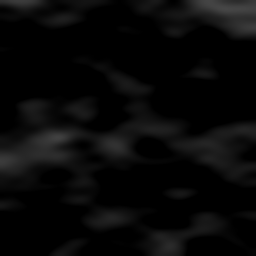

In [29]:
idct_image = Image.fromarray(imgIDCT)
idct_image=idct_image.convert("P")
display(idct_image)

In [30]:
imgIDCT = imgIDCT.T
idct_image = Image.fromarray(imgIDCT)

Text(0.5, 1.0, 'IDCT Imagem - 100 Amostras')

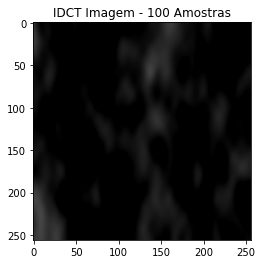

In [31]:
plt.imshow(idct_image, cmap="gray")
plt.title("IDCT Imagem - {} Amostras".format(samples))

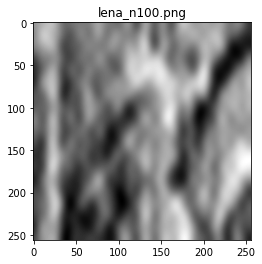

In [32]:
image_n100 = readImageByPath ("utils/lena_n100.png")

Dada uma imagem I em níveis de cinza, de dimensões RxC, desenvolva um programa para:

1.1 Exibir o módulo normalizado da DCT de I, sem o nível DC, e o valor (numérico) do nível DC

1.2. Encontrar e exibir uma aproximação de I obtida preservando o coeficiente DC e os n coeficientes AC mais importantes de I, e zerando os demais. O parâmetro n é um inteiro no intervalo [0, RxC-1].

In [33]:
imagem = Image.open("utils/lena.bmp")
imagem = np.asarray(imagem)

#### 1.2. Encontrar e exibir uma aproximação de I obtida preservando o coeficiente DC e os n coeficientes AC mais importantes de I, e zerando os demais. O parâmetro n é um inteiro no intervalo [0, RxC-1].